<a href="https://colab.research.google.com/github/jieun0441/XMC/blob/main/Code_Fig2_Ext_Fig_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seoul data analysis: code for the model fitting (and KS distance)
## creates figures 2, extended figure 6 and 7


#population distribution

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[Cell 1] Loaded populations for 426 dongs.
[Cell 1] Totals:
 - Households total     : 4,463,385
 - Registered pop total : 9,668,008
 - De facto pop total   : 10,446,532


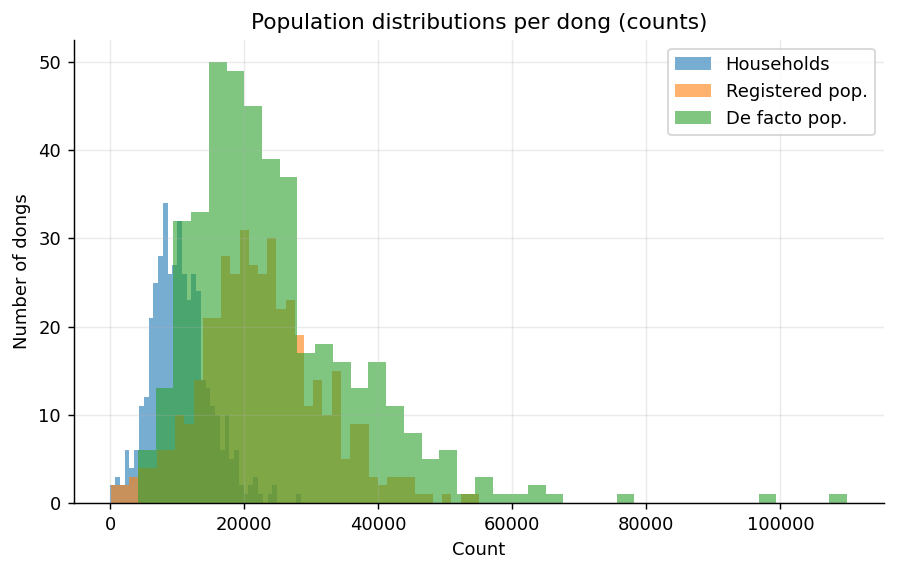

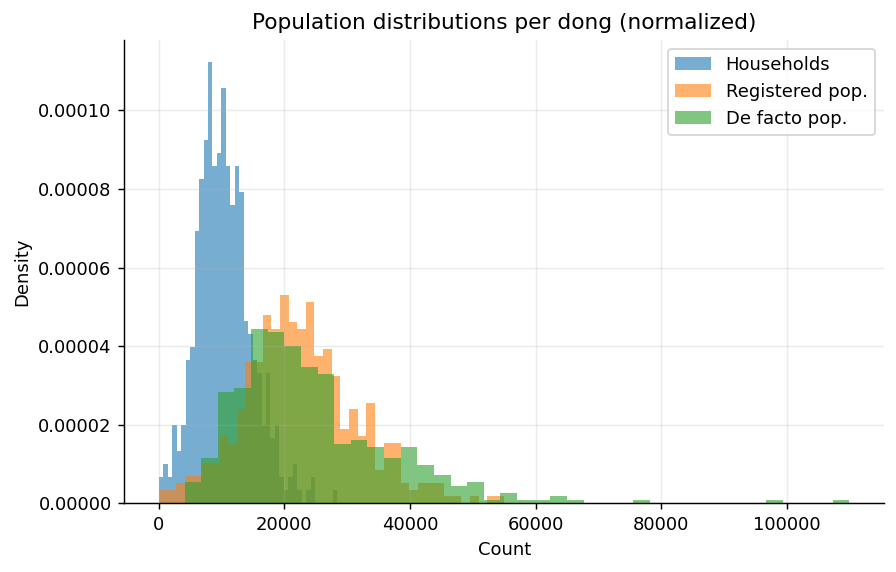

In [ ]:
# ============================================
# Cell 1 — Load populations and plot histograms (counts + normalized)
# Files:
#   - population_Seoul_426dong_2023.xlsx  (Sheet1)
# Columns:
#   dong_cd, household, regist_pop, defacto_pop
# Notes:
#   - We'll mainly use 'defacto_pop' downstream.
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------- Config -----------
data_dir = "/content/drive/MyDrive/FMC_Data/Sharing_to_Public"
pop_file = os.path.join(data_dir, "population_Seoul_426dong_2023.xlsx")
pop_sheet = "Sheet1"

# Matplotlib defaults
plt.rcParams.update({
    "figure.dpi": 130,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ----------- Load -----------
df_pop = pd.read_excel(pop_file, sheet_name=pop_sheet, engine="openpyxl")

# Standardize column names and types
df_pop = df_pop.rename(columns={
    "dong_cd": "dong_cd",
    "household": "household",
    "regist_pop": "regist_pop",
    "defacto_pop": "defacto_pop"
})
# Ensure IDs are strings (important for merges)
df_pop["dong_cd"] = df_pop["dong_cd"].astype(str)

# Basic sanity checks
assert {"dong_cd", "household", "regist_pop", "defacto_pop"}.issubset(df_pop.columns)
n_dong = df_pop["dong_cd"].nunique()
print(f"[Cell 1] Loaded populations for {n_dong} dongs.")

# ----------- Totals (requested) -----------
tot_households = float(df_pop["household"].sum())      # [NEW]
tot_regist     = float(df_pop["regist_pop"].sum())     # [NEW]
tot_defacto    = float(df_pop["defacto_pop"].sum())    # [NEW]

print("[Cell 1] Totals:")                               # [NEW]
print(f" - Households total     : {tot_households:,.0f}")  # [NEW]
print(f" - Registered pop total : {tot_regist:,.0f}")      # [NEW]
print(f" - De facto pop total   : {tot_defacto:,.0f}")     # [NEW]

# ----------- Histograms (counts) -----------
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))
bins = 40

ax.hist(df_pop["household"].dropna().values, bins=bins, alpha=0.6, label="Households")
ax.hist(df_pop["regist_pop"].dropna().values, bins=bins, alpha=0.6, label="Registered pop.")
ax.hist(df_pop["defacto_pop"].dropna().values, bins=bins, alpha=0.6, label="De facto pop.")

ax.set_xlabel("Count")
ax.set_ylabel("Number of dongs")
ax.set_title("Population distributions per dong (counts)")
ax.legend()
plt.tight_layout()
plt.show()

# ----------- Histograms (normalized densities) -----------
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))         # [NEW]
ax.hist(df_pop["household"].dropna().values, bins=bins, alpha=0.6, density=True, label="Households")   # [NEW]
ax.hist(df_pop["regist_pop"].dropna().values, bins=bins, alpha=0.6, density=True, label="Registered pop.")  # [NEW]
ax.hist(df_pop["defacto_pop"].dropna().values, bins=bins, alpha=0.6, density=True, label="De facto pop.")   # [NEW]
ax.set_xlabel("Count")                                  # [NEW]
ax.set_ylabel("Density")                                # [NEW]
ax.set_title("Population distributions per dong (normalized)")  # [NEW]
ax.legend()                                             # [NEW]
plt.tight_layout()                                      # [NEW]
plt.show()                                              # [NEW]


# dong interdistance distribution

[Cell 2] Loaded distance tables:
 - same=0          : (181476, 3)
 - same=radius     : (181476, 3)
 - without sameOD  : (181050, 3)


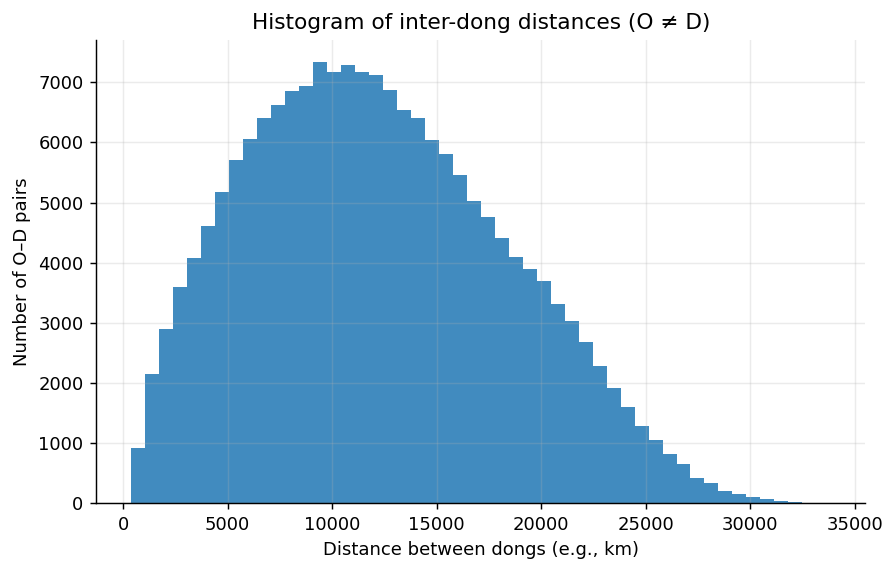

In [ ]:
# ============================================
# Cell 2 — Load distance matrices; histogram of inter-dong distances
# Files:
# - Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_if_same_filled_zero.csv
# - Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_if_same_filled_radius_assuming_circle.csv
# - Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_without_sameOD
#
# We will keep all three; for the histogram, we use the "radius_if_same" file
# and EXCLUDE self pairs (O != D).
# Columns: O_ADMDONG_CD, D_ADMDONG_CD, Distance
# ============================================

dist_zero_file = os.path.join(
    data_dir,
    "Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_if_same_filled_zero.csv"
)
dist_radius_file = os.path.join(
    data_dir,
    "Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_if_same_filled_radius_assuming_circle.csv"
)
dist_wo_same_file = os.path.join(
    data_dir,
    "Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_without_sameOD.csv"
)

usecols = ["O_ADMDONG_CD", "D_ADMDONG_CD", "Distance"]
dtype_ids = {"O_ADMDONG_CD": str, "D_ADMDONG_CD": str}

df_dist_zero   = pd.read_csv(dist_zero_file, usecols=usecols, dtype=dtype_ids)
df_dist_radius = pd.read_csv(dist_radius_file, usecols=usecols, dtype=dtype_ids)
# The third file may or may not have an extension; try to read flexibly
try:
    df_dist_wo_same = pd.read_csv(dist_wo_same_file, usecols=usecols, dtype=dtype_ids)
except Exception:
    # try with .csv appended
    try:
        df_dist_wo_same = pd.read_csv(dist_wo_same_file + ".csv", usecols=usecols, dtype=dtype_ids)
    except Exception as e:
        print(f"[Cell 2] Could not load without_sameOD file directly: {e}")
        df_dist_wo_same = None

print(f"[Cell 2] Loaded distance tables:")
print(f" - same=0          : {df_dist_zero.shape}")
print(f" - same=radius     : {df_dist_radius.shape}")
print(f" - without sameOD  : {None if df_dist_wo_same is None else df_dist_wo_same.shape}")

# Histogram of distances BETWEEN DIFFERENT dongs from the radius file
mask_inter = df_dist_radius["O_ADMDONG_CD"] != df_dist_radius["D_ADMDONG_CD"]
distvals = df_dist_radius.loc[mask_inter, "Distance"].astype(float).values

plt.figure(figsize=(7, 4.5))
plt.hist(distvals, bins=50, alpha=0.85)
plt.xlabel("Distance between dongs (e.g., km)")
plt.ylabel("Number of O–D pairs")
plt.title("Histogram of inter-dong distances (O ≠ D)")
plt.tight_layout()
plt.show()

# For later use, keep a fast distance pivot/matrix with same=radius
# Build index order from population table to keep consistent ordering
dong_ids = df_pop["dong_cd"].tolist()
id_to_idx = {d: i for i, d in enumerate(dong_ids)}
n = len(dong_ids)

# Initialize full distance matrix with NaN
dist_matrix = np.full((n, n), np.nan, dtype=float)
for _, row in df_dist_radius.iterrows():
    i = id_to_idx.get(row["O_ADMDONG_CD"])
    j = id_to_idx.get(row["D_ADMDONG_CD"])
    if i is not None and j is not None:
        dist_matrix[i, j] = float(row["Distance"])

# Sanity: self distances should be positive radii in the radius file
self_radii = np.diag(dist_matrix)
if np.any(~np.isfinite(self_radii)) or np.any(self_radii <= 0):
    print("[Cell 2][WARN] Some self distances (radii) missing or non-positive. Check input.")


# Trip distribution

In [ ]:
# ============================================
# Cell 3a — OD trip distributions (counts) with robust tail fits
# Figures:
#   (1) Raw histograms (lin–log)
#   (2) SAME histograms + exponential tail fits (expected counts)
#   (3) SAME histograms + power-law tail fits (expected counts)
#   (4) NW-only: Exp, Power-law, Truncated (PL×Exp) fits (expected counts)
#   (5) W-only:  Exp, Power-law, Truncated (PL×Exp) fits (expected counts)
#
# Tail strategy:
#   • Choose x_min by KS minimization for Exp and PL (on raw samples).
#   • Truncated PL (x^{-α} e^{-λ x}): fit A, α, λ to tail-bin COUNTS via bounded least squares on bins.
# All overlays are EXPECTED COUNTS, matching histogram y-scale.
# Prints: parameters and R^2 for each tail fit (computed on tail bins).
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy import optimize

# ----- Load datasets -----
nw_file = os.path.join(data_dir, "Tij_NonworkTrips_P24567_in2023.xlsx")
w_file  = os.path.join(data_dir, "Tij_P1_Going_to_Work_in2023.xlsx")

usecols_t = ["O_ADMDONG_CD", "D_ADMDONG_CD", "CNT"]
df_T_nw = pd.read_excel(nw_file, usecols=usecols_t, engine="openpyxl")
df_T_w  = pd.read_excel(w_file , usecols=usecols_t, engine="openpyxl")

for dfT in (df_T_nw, df_T_w):
    dfT["O_ADMDONG_CD"] = dfT["O_ADMDONG_CD"].astype(str)
    dfT["D_ADMDONG_CD"] = dfT["D_ADMDONG_CD"].astype(str)
    dfT["CNT"] = pd.to_numeric(dfT["CNT"], errors="coerce").fillna(0.0)

print(f"[Cell 3a] Trips loaded: non-work {df_T_nw.shape}, work {df_T_w.shape}")

# ----- Prepare CNT arrays (finite, non-negative) -----
cnt_nw = df_T_nw["CNT"].to_numpy(float)
cnt_w  = df_T_w ["CNT"].to_numpy(float)
m_nw = np.isfinite(cnt_nw) & (cnt_nw >= 0)
m_w  = np.isfinite(cnt_w ) & (cnt_w  >= 0)
cnt_nw = cnt_nw[m_nw]
cnt_w  = cnt_w [m_w ]

# >>> NEW: summary stats before any fits <<<
N_nw = cnt_nw.size
N_w  = cnt_w.size
mean_nw = float(np.mean(cnt_nw)) if N_nw > 0 else np.nan
mean_w  = float(np.mean(cnt_w )) if N_w  > 0 else np.nan
std_nw  = float(np.std(cnt_nw, ddof=0)) if N_nw > 1 else np.nan   # population std
std_w   = float(np.std(cnt_w , ddof=0)) if N_w  > 1 else np.nan   # population std
print("[Cell 3a] Summary stats (CNT per O–D):")
print(f" - Non-work: N={N_nw:,d}, mean={mean_nw:.6g}, std={std_nw:.6g}")
print(f" - Work    : N={N_w : ,d}, mean={mean_w :.6g}, std={std_w :.6g}")

pooled = np.concatenate([cnt_nw, cnt_w])
if pooled.size == 0:
    raise ValueError("[Cell 3a] No valid CNT values to plot.")

# ----- Common bins (reuse across all figures) -----
# Freedman–Diaconis on pooled data; cap bins for stability
q75, q25 = np.nanpercentile(pooled, [75, 25])
iqr = q75 - q25
n = pooled.size
if iqr > 0 and n > 0:
    bw = 2 * iqr / (n ** (1/3))
    if bw > 0:
        nb = int(np.clip(np.ceil((pooled.max() - pooled.min()) / bw), 20, 120))
    else:
        nb = 60
else:
    nb = 60




[Cell 3a] Trips loaded: non-work (181476, 3), work (176385, 3)
[Cell 3a] Summary stats (CNT per O–D):
 - Non-work: N=181,476, mean=13670.3, std=99180.4
 - Work    : N= 176,385, mean=3930.53, std=16220.8


# OT/IT totals and their distributions

[Cell 4] OD matrices ready: T_w (426, 426), T_nw (426, 426)
[Cell 4] Example rows (OT/IT):


,dong_cd,OT_total,IT_total,OT_w,IT_w,OT_nw,IT_nw
0,11110515,6974158.82,7503313.74,900156.66,1073504.32,6074002.16,6429809.42
1,11110530,11517348.80,18912055.37,1181525.98,6015553.54,10335822.82,12896501.83
2,11110540,2819593.02,3878663.06,215030.94,636115.02,2604562.08,3242548.04
3,11110550,3972094.16,3796864.83,673312.93,485608.84,3298781.23,3311255.99
4,11110560,5708324.27,4177727.74,1123151.65,568389.02,4585172.62,3609338.72


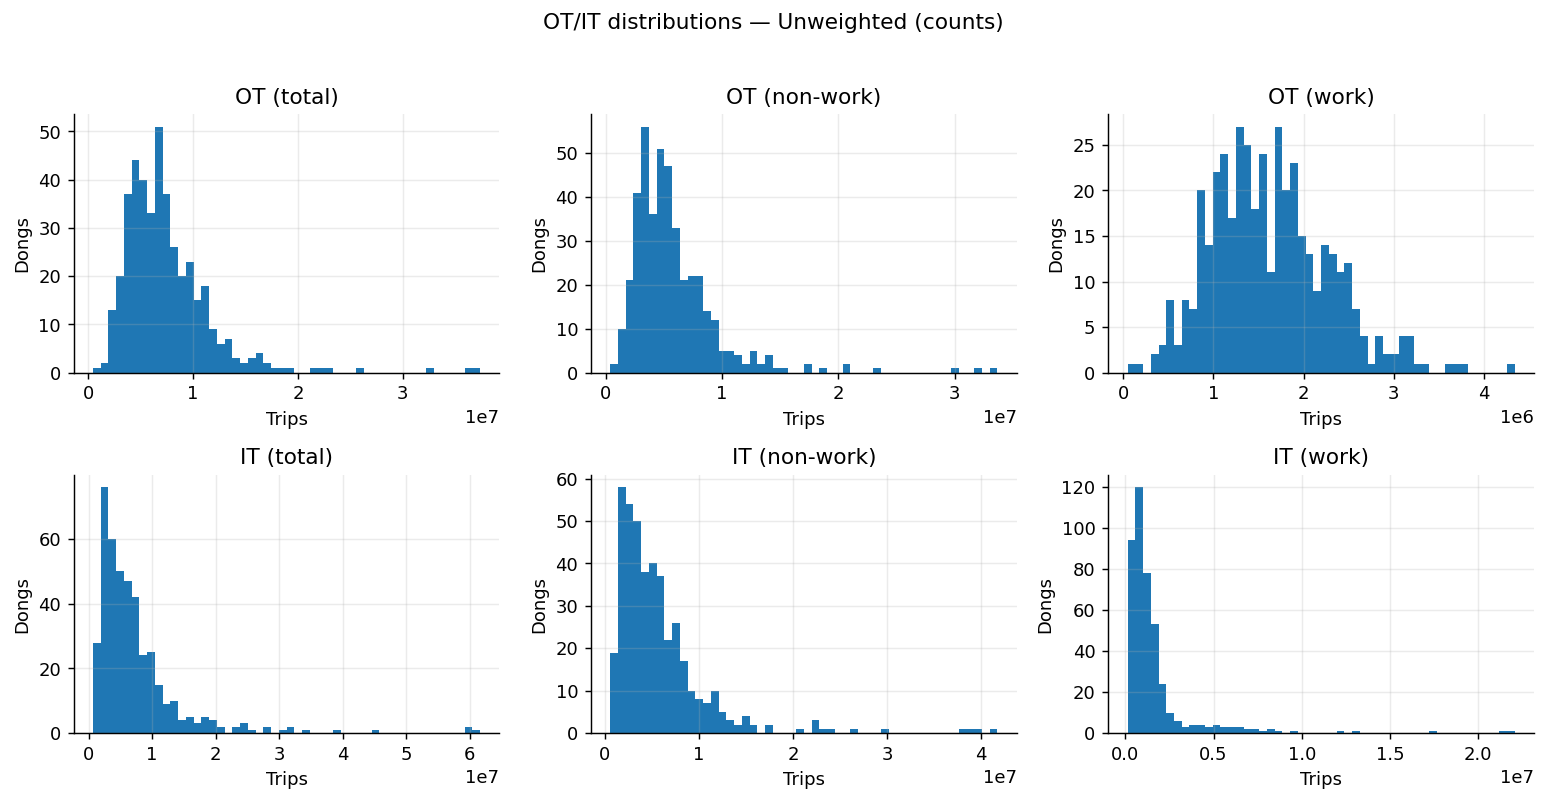

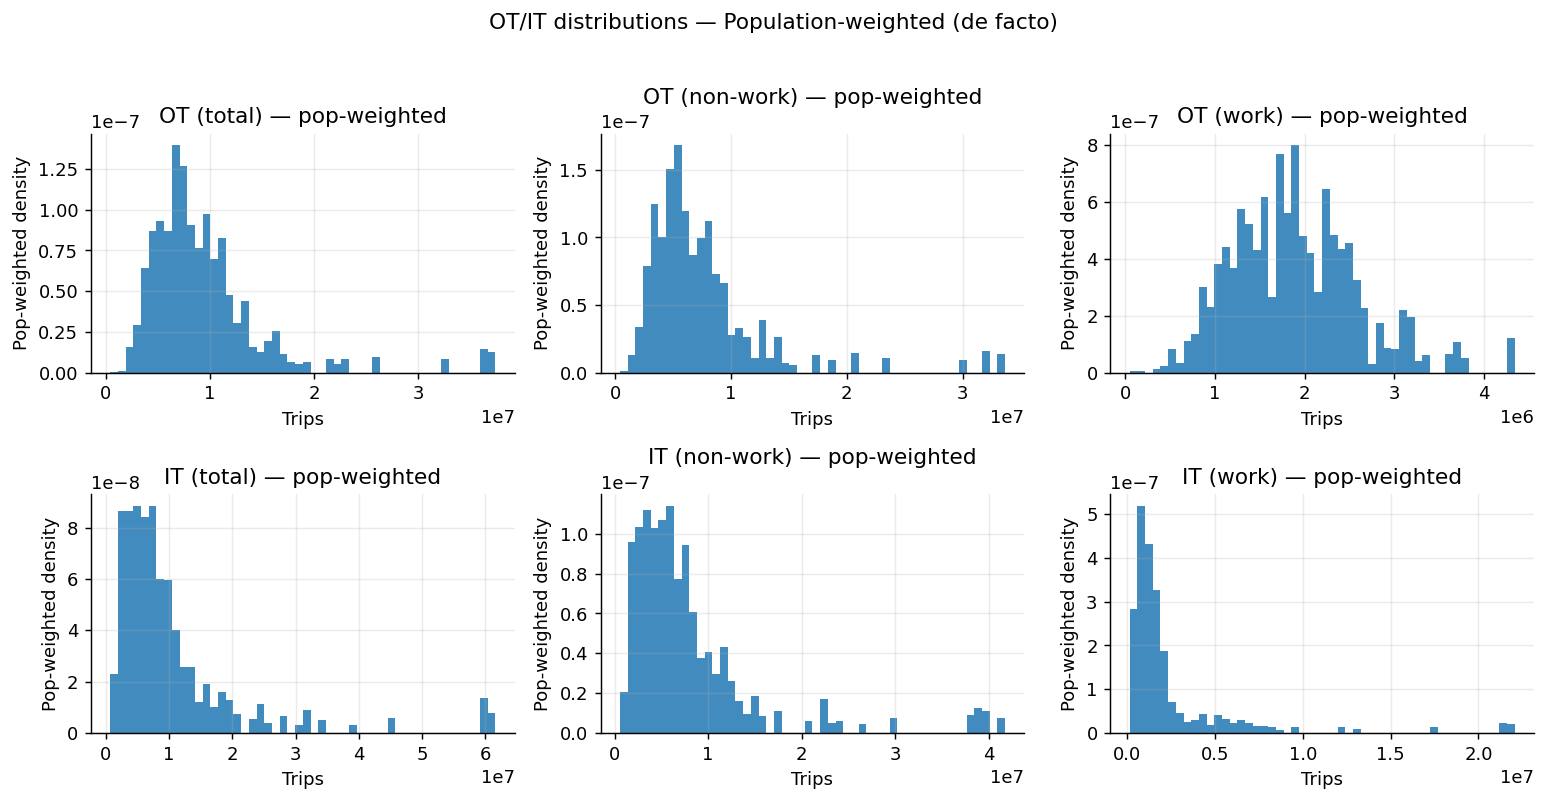

In [ ]:
# ============================================
# Cell 4 — OT/IT totals and their distributions
# Cases:
#   - total = work + nonwork
#   - work
#   - nonwork
# Plots:
#   - Unweighted histograms (counts)
#   - Population-weighted histograms (weights = de facto pop)
#     Layout for both: Row 1 = OT (total, nonwork, work),
#                      Row 2 = IT (total, nonwork, work)
# ============================================

# ---------------------------------------------
# [NEW] Prepare OD matrices for work / non-work
# ---------------------------------------------
# Get full ordered list of dong codes
dong_ids = sorted(set(df_T_w["O_ADMDONG_CD"]) | set(df_T_w["D_ADMDONG_CD"])
                  | set(df_T_nw["O_ADMDONG_CD"]) | set(df_T_nw["D_ADMDONG_CD"]))
n_dong = len(dong_ids)

# Map dong codes to matrix indices
dong_to_idx = {d: i for i, d in enumerate(dong_ids)}

# Initialize matrices
T_w  = np.zeros((n_dong, n_dong), dtype=float)
T_nw = np.zeros((n_dong, n_dong), dtype=float)

# Fill them
for _, row in df_T_w.iterrows():
    i = dong_to_idx.get(row["O_ADMDONG_CD"])
    j = dong_to_idx.get(row["D_ADMDONG_CD"])
    if i is not None and j is not None:
        T_w[i, j] = row["CNT"]

for _, row in df_T_nw.iterrows():
    i = dong_to_idx.get(row["O_ADMDONG_CD"])
    j = dong_to_idx.get(row["D_ADMDONG_CD"])
    if i is not None and j is not None:
        T_nw[i, j] = row["CNT"]

print(f"[Cell 4] OD matrices ready: T_w {T_w.shape}, T_nw {T_nw.shape}")


# Totals
T_total = T_w + T_nw

def OT_IT_dists(T):
    OT = T.sum(axis=1)
    IT = T.sum(axis=0)
    return OT, IT

OT_tot, IT_tot = OT_IT_dists(T_total)
OT_w , IT_w_  = OT_IT_dists(T_w)
OT_nw, IT_nw_ = OT_IT_dists(T_nw)

df_OT_IT = pd.DataFrame({
    "dong_cd": dong_ids,
    "OT_total": OT_tot, "IT_total": IT_tot,
    "OT_w": OT_w, "IT_w": IT_w_,
    "OT_nw": OT_nw, "IT_nw": IT_nw_
})

print("[Cell 4] Example rows (OT/IT):")
display(df_OT_IT.head())

# -----------------------------
# Prepare population weights
# -----------------------------
# Align de facto population with dong_ids
pop_ordered = (
    df_pop.set_index("dong_cd")
          .loc[dong_ids, "defacto_pop"]
          .astype(float)
          .fillna(0.0)
          .clip(lower=0.0)
          .to_numpy()
)
tot_pop = float(pop_ordered.sum())
if tot_pop <= 0:
    print("[Cell 4][WARN] All de facto populations are zero/NaN; weighted histograms will match unweighted.")

# -----------------------------
# Unweighted histograms (counts)
# -----------------------------
fig, axs = plt.subplots(2, 3, figsize=(12, 6))  # [NEW layout]
axs = axs  # shape (2,3)

bins = 50

# Row 1: OT (total, non-work, work)
axs[0, 0].hist(OT_tot, bins=bins)
axs[0, 0].set_title("OT (total)")
axs[0, 0].set_xlabel("Trips"); axs[0, 0].set_ylabel("Dongs")

axs[0, 1].hist(OT_nw, bins=bins)
axs[0, 1].set_title("OT (non-work)")
axs[0, 1].set_xlabel("Trips"); axs[0, 1].set_ylabel("Dongs")

axs[0, 2].hist(OT_w, bins=bins)
axs[0, 2].set_title("OT (work)")
axs[0, 2].set_xlabel("Trips"); axs[0, 2].set_ylabel("Dongs")

# Row 2: IT (total, non-work, work)
axs[1, 0].hist(IT_tot, bins=bins)
axs[1, 0].set_title("IT (total)")
axs[1, 0].set_xlabel("Trips"); axs[1, 0].set_ylabel("Dongs")

axs[1, 1].hist(IT_nw_, bins=bins)
axs[1, 1].set_title("IT (non-work)")
axs[1, 1].set_xlabel("Trips"); axs[1, 1].set_ylabel("Dongs")

axs[1, 2].hist(IT_w_, bins=bins)
axs[1, 2].set_title("IT (work)")
axs[1, 2].set_xlabel("Trips"); axs[1, 2].set_ylabel("Dongs")

plt.suptitle("OT/IT distributions — Unweighted (counts)", y=1.02)  # [NEW]
plt.tight_layout()
plt.show()

# ---------------------------------------------
# Population-weighted histograms (density)
# ---------------------------------------------
# Interpretation: each dong contributes proportionally to its de facto population.
if tot_pop > 0:
    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    bins = 50

    # Row 1: OT (total, non-work, work)
    axs[0, 0].hist(OT_tot, bins=bins, density=True, weights=pop_ordered, alpha=0.85)
    axs[0, 0].set_title("OT (total) — pop-weighted")
    axs[0, 0].set_xlabel("Trips"); axs[0, 0].set_ylabel("Pop-weighted density")

    axs[0, 1].hist(OT_nw, bins=bins, density=True, weights=pop_ordered, alpha=0.85)
    axs[0, 1].set_title("OT (non-work) — pop-weighted")
    axs[0, 1].set_xlabel("Trips"); axs[0, 1].set_ylabel("Pop-weighted density")

    axs[0, 2].hist(OT_w, bins=bins, density=True, weights=pop_ordered, alpha=0.85)
    axs[0, 2].set_title("OT (work) — pop-weighted")
    axs[0, 2].set_xlabel("Trips"); axs[0, 2].set_ylabel("Pop-weighted density")

    # Row 2: IT (total, non-work, work)
    axs[1, 0].hist(IT_tot, bins=bins, density=True, weights=pop_ordered, alpha=0.85)
    axs[1, 0].set_title("IT (total) — pop-weighted")
    axs[1, 0].set_xlabel("Trips"); axs[1, 0].set_ylabel("Pop-weighted density")

    axs[1, 1].hist(IT_nw_, bins=bins, density=True, weights=pop_ordered, alpha=0.85)
    axs[1, 1].set_title("IT (non-work) — pop-weighted")
    axs[1, 1].set_xlabel("Trips"); axs[1, 1].set_ylabel("Pop-weighted density")

    axs[1, 2].hist(IT_w_, bins=bins, density=True, weights=pop_ordered, alpha=0.85)
    axs[1, 2].set_title("IT (work) — pop-weighted")
    axs[1, 2].set_xlabel("Trips"); axs[1, 2].set_ylabel("Pop-weighted density")

    plt.suptitle("OT/IT distributions — Population-weighted (de facto)", y=1.02)
    plt.tight_layout()
    plt.show()


# Fitting the models (C and D): minimizing the KS distance

## helper functions

In [ ]:
# ============================================
# Cell A — Shared models, simulators, and metrics (with proper KS weighting)
# Models use dist_matrix AS-IS (diagonal may already be non-zero)
#   Model C: P_ij ∝ d_ij^(-γ)
#   Model D: P_ij ∝ d_ij^(-γ) * Pj   (Pj = de-facto population)
#
# Provides:
#   - build_P_modelC(D, γ), build_P_modelD(D, γ, Pj)
#   - simulate_from_OT(OT, P)
#   - mean_IT_reducedOT(T_emp, P, N_sims, f)
#   - mean_SC_PE_empOT(T_emp, P, N_sims)  [SC = T_ii/OT_i ; PE = destination share = IT/T_tot]
#   - ks_distance_unweighted(a, b)
#   - ks_distance_weighted(a, b, w_a=None, w_b=None)
#   - ks_for(quantity_name, emp_vec, model_vec, weights_pop)  # dispatches weighting rule:
#       * 'SC' and 'PE' → population-weighted KS
#       * 'IT'          → unweighted KS
#   - plotting helpers: plot_ks_traces(...), plot_J_traces(...)
#
# Requirements in global scope:
#   T_nw, T_w, dist_matrix, dong_ids, df_pop, compute_PE (PE = destination share)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# ============================================
# Support function required before Cell A
# ============================================

def compute_PE(T):
    """
    Compute PE(i) = IT(i) / sum_{m,n} T_{mn}.
    Returns (PE, IT, T_total)
      - PE : vector of destination shares (sum_i PE(i) = 1)
      - IT : incoming flows per dong
      - T_total : total number of trips
    """
    T = np.asarray(T, float)
    total = T.sum()
    IT = T.sum(axis=0)        # incoming per destination
    with np.errstate(divide="ignore", invalid="ignore"):
        PE = np.where(total > 0, IT / total, 0.0)
    return PE, IT, total


# ---------- Guards ----------
_missing = []
for name in ["T_nw", "T_w", "dist_matrix", "dong_ids", "df_pop", "compute_PE"]:
    if name not in globals():
        _missing.append(name)
if _missing:
    raise RuntimeError(f"[Cell A] Missing required objects: {', '.join(_missing)}")

# ---------- Optional tqdm ----------
try:
    from tqdm.auto import tqdm
    USE_TQDM = True
except Exception:
    USE_TQDM = False

# ---------- Population vector for Model D & for KS weighting ----------
weights_pop = (
    df_pop.set_index("dong_cd")
          .loc[dong_ids, "defacto_pop"]
          .astype(float).fillna(0.0).clip(lower=0.0)
          .to_numpy()
)
Pj_pop = weights_pop

# ---------- Distances (as-is, minor clipping for numerical stability) ----------
D = np.asarray(dist_matrix, float)
if D.shape[0] != D.shape[1]:
    raise ValueError("[Cell A] dist_matrix must be square.")
n = D.shape[0]
D_pos = np.maximum(D, 1e-12)   # avoid divide-by-zero only

# ---------- Models ----------
def build_P_modelC(D_pos, gamma):
    """Model C: P_ij ∝ d_ij^(-γ)  (row-stochastic)."""
    with np.errstate(divide='ignore', invalid='ignore'):
        W = np.power(D_pos, -gamma, dtype=float)
    W[(~np.isfinite(W)) | (W < 0)] = 0.0
    P = np.zeros_like(W, dtype=float)
    for i in range(W.shape[0]):
        s = W[i].sum()
        P[i, :] = (W[i] / s) if s > 0 else (np.ones(W.shape[1]) / W.shape[1])
    return P

def build_P_modelD(D_pos, gamma, Pj):
    """Model D: P_ij ∝ d_ij^(-γ) * Pj  (row-stochastic)."""
    with np.errstate(divide='ignore', invalid='ignore'):
        W0 = np.power(D_pos, -gamma, dtype=float)
    W0[(~np.isfinite(W0)) | (W0 < 0)] = 0.0
    Pj = np.asarray(Pj, float)
    Pj = np.where(np.isfinite(Pj) & (Pj > 0), Pj, 0.0)
    P = np.zeros_like(W0, dtype=float)
    for i in range(W0.shape[0]):
        w = W0[i] * Pj
        s = w.sum()
        P[i, :] = (w / s) if s > 0 else (np.ones(W0.shape[1]) / W0.shape[1])
    return P

# ---------- Empirical quantities ----------
def OT_IT_from(T):
    return T.sum(axis=1), T.sum(axis=0)

def SC_share_from(T):
    OT = T.sum(axis=1)
    diag = np.diag(T)
    SC = np.zeros_like(OT, dtype=float)
    m = OT > 0
    SC[m] = diag[m] / OT[m]
    return SC

def PE_dest_share_from(T):
    """Uses your compute_PE(T) which returns destination share as first output."""
    PE, _, _ = compute_PE(T)
    return PE

# ---------- Simulators ----------
_rng_master = np.random.default_rng(42)  # master RNG

# --- PATCH START (put in Cell A, replacing the old defs) ---

# Optional RNG-aware simulate (accepts rng=)
def simulate_from_OT(OT_vec, P_mat, rng=None):  # <-- CHANGED: added rng parameter
    """
    Multinomial draws per origin using integer OT_vec.
    If rng is None, uses a local Generator.
    """
    if rng is None:                              # <-- CHANGED: default RNG behavior
        rng = np.random.default_rng()
    n = len(OT_vec)
    T_sim = np.zeros((n, n), dtype=float)
    for i in range(n):
        n_i = int(np.rint(float(OT_vec[i])))
        if n_i <= 0:
            continue
        T_sim[i, :] = rng.multinomial(n_i, P_mat[i], size=1)[0]
    return T_sim

def mean_IT_reducedOT(T_emp, P_mat, N_sims=100, f=0.10, seed=None):  # <-- CHANGED: consistent signature
    """
    Mean IT over sims with OT_sim = round(f * OT_emp).
    Accepts optional seed for reproducibility.
    """
    OT_emp = T_emp.sum(axis=1)
    n = T_emp.shape[0]
    IT_sims = np.zeros((N_sims, n))
    # set up RNG (reproducible if seed provided)
    rng = np.random.default_rng(seed)            # <-- CHANGED: create rng once, pass down
    for s_idx in range(N_sims):
        OT_sim = np.rint(f * OT_emp).astype(int) # <-- CHANGED: build integer OT once per sim
        T_sim = simulate_from_OT(OT_sim, P_mat, rng=rng)  # <-- CHANGED: pass rng=
        IT_sims[s_idx, :] = T_sim.sum(axis=0)
    return IT_sims.mean(axis=0)

def mean_SC_PE_empOT(T_emp, P_mat, N_sims=100, seed=None):  # <-- CHANGED: optional seed for symmetry
    """
    Mean SC and PE over sims with OT_sim = OT_emp (scale-free).
    """
    OT_emp = T_emp.sum(axis=1)
    n = T_emp.shape[0]
    SC_sims = np.zeros((N_sims, n))
    PE_sims = np.zeros((N_sims, n))
    rng = np.random.default_rng(seed)            # <-- CHANGED: create rng once, pass down
    for s_idx in range(N_sims):
        T_sim = simulate_from_OT(OT_emp, P_mat, rng=rng)  # <-- CHANGED: pass rng=
        SC_sims[s_idx, :], _ = compute_SC(T_sim)
        PE_sims[s_idx, :], _, _ = compute_PE(T_sim)
    return SC_sims.mean(axis=0), PE_sims.mean(axis=0)

# --- PATCH END ---

def mean_SC_PE_empOT(T_emp, P_mat, N_sims=100, seed=42):
    """Simulate with empirical OT; return mean SC and mean PE (destination share)."""
    rng = np.random.default_rng(seed)
    OT_emp = T_emp.sum(axis=1)
    SC_sims = np.zeros((N_sims, T_emp.shape[0]))
    PE_sims = np.zeros((N_sims, T_emp.shape[0]))
    for s_idx in range(N_sims):
        T_sim = simulate_from_OT(OT_emp, P_mat, rng=rng)
        # SC
        OT = T_sim.sum(axis=1); diag = np.diag(T_sim)
        SC = np.zeros_like(OT, dtype=float); m = OT > 0
        SC[m] = diag[m] / OT[m]
        SC_sims[s_idx, :] = SC
        # PE (destination share)
        PE_sims[s_idx, :] = PE_dest_share_from(T_sim)
    return SC_sims.mean(axis=0), PE_sims.mean(axis=0)

# ---------- KS metrics ----------
def ks_distance_unweighted(a, b):
    """Standard two-sample KS (unweighted)."""
    a = np.asarray(a, float); b = np.asarray(b, float)
    m = np.isfinite(a); a = a[m]
    m = np.isfinite(b); b = b[m]
    if a.size < 2 or b.size < 2:
        return np.inf
    return float(ks_2samp(a, b, alternative='two-sided', mode='auto').statistic)

def ks_distance_weighted(a, b, w_a=None, w_b=None):
    """
    Two-sample KS with optional nonnegative weights.
    Weights need not sum to 1 (we renormalize internally).
    """
    a = np.asarray(a, float); b = np.asarray(b, float)
    if w_a is None: w_a = np.ones_like(a, float)
    if w_b is None: w_b = np.ones_like(b, float)
    # Mask invalids consistently
    ma = np.isfinite(a) & np.isfinite(w_a) & (w_a >= 0)
    mb = np.isfinite(b) & np.isfinite(w_b) & (w_b >= 0)
    a, w_a = a[ma], w_a[ma]
    b, w_b = b[mb], w_b[mb]
    if a.size < 2 or b.size < 2:
        return np.inf
    # Normalize weights
    sa, sb = w_a.sum(), w_b.sum()
    if sa <= 0 or sb <= 0:
        return np.inf
    w_a = w_a / sa; w_b = w_b / sb
    # Sort
    ia = np.argsort(a); a_s, wa_s = a[ia], w_a[ia]
    ib = np.argsort(b); b_s, wb_s = b[ib], w_b[ib]
    # Merge grid
    xs = np.unique(np.concatenate([a_s, b_s]))
    cdfa = np.interp(xs, a_s, np.cumsum(wa_s), left=0, right=1)
    cdfb = np.interp(xs, b_s, np.cumsum(wb_s), left=0, right=1)
    return float(np.max(np.abs(cdfa - cdfb)))

def ks_for(quantity_name, emp_vec, model_vec, weights_pop):
    """
    Dispatch KS according to quantity:
      - 'SC' and 'PE' → population-weighted KS
      - 'IT'          → unweighted KS
    """
    emp_vec  = np.asarray(emp_vec, float)
    model_vec = np.asarray(model_vec, float)
    w = np.asarray(weights_pop, float)

    valid = np.isfinite(emp_vec) & np.isfinite(model_vec) & np.isfinite(w) & (w >= 0)
    if valid.sum() < 2:
        return np.inf

    if quantity_name in ("SC", "PE"):
        return ks_distance_weighted(emp_vec[valid], model_vec[valid], w_a=w[valid], w_b=w[valid])
    elif quantity_name == "IT":
        return ks_distance_unweighted(emp_vec[valid], model_vec[valid])
    else:
        raise ValueError(f"ks_for: unknown quantity '{quantity_name}' (expected 'SC','PE','IT').")

# ---------- Multi-objective (SC, IT_scaled, PE) ----------
def objective_J(sc_emp, it_emp_scaled, pe_emp, sc_hat, it_hat, pe_hat,
                weights=(1/3, 1/3, 1/3), pop_w=None):
    """
    Combines KS terms with user weights; applies correct weighting policy:
      - SC, PE → population-weighted KS
      - IT     → unweighted KS
    """
    k1 = ks_for("SC", sc_emp,        sc_hat, pop_w)
    k2 = ks_for("IT", it_emp_scaled, it_hat, pop_w)
    k3 = ks_for("PE", pe_emp,        pe_hat, pop_w)
    return (weights[0]*k1 + weights[1]*k2 + weights[2]*k3), (k1, k2, k3)

# ---------- Plotting helpers ----------
def plot_ks_traces(ks_traces, gamma_grid, title_pairs, ylabel="KS distance"):
    """title_pairs: list of (key, plot_title); ks_traces[key]['C'/'D'] = arrays."""
    R = int(np.ceil(len(title_pairs)/2))
    C = 2 if len(title_pairs) > 1 else 1
    fig, axs = plt.subplots(R, C, figsize=(12.5, 4.0*R), sharex=True, sharey=True)
    axs = np.array(axs).ravel() if isinstance(axs, (list, np.ndarray)) else np.array([axs])
    for ax, (key, ttl) in zip(axs, title_pairs):
        ksC = ks_traces[key]["C"]; ksD = ks_traces[key]["D"]
        ax.plot(gamma_grid, ksC, lw=2.0, label="Model C")
        ax.plot(gamma_grid, ksD, lw=2.0, label="Model D")
        if np.isfinite(ksC).any():
            iC = int(np.nanargmin(ksC)); ax.plot(gamma_grid[iC], ksC[iC], 'o')
            ax.annotate(f"γ*={gamma_grid[iC]:.2f}\nKS={ksC[iC]:.3f}",
                        (gamma_grid[iC], ksC[iC]), textcoords="offset points", xytext=(6,6), fontsize=9)
        if np.isfinite(ksD).any():
            iD = int(np.nanargmin(ksD)); ax.plot(gamma_grid[iD], ksD[iD], 'o')
            ax.annotate(f"γ*={gamma_grid[iD]:.2f}\nKS={ksD[iD]:.3f}",
                        (gamma_grid[iD], ksD[iD]), textcoords="offset points", xytext=(6,-18), fontsize=9)
        ax.set_title(ttl); ax.set_xlabel(r"$\gamma$"); ax.set_ylabel(ylabel); ax.grid(True, alpha=0.25)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2)
    try: plt.tight_layout(rect=[0, 0, 1, 0.93])
    except Exception: pass
    plt.show()

def plot_J_traces(J_traces, gamma_grid, f):
    fig, axs = plt.subplots(1, 2, figsize=(12.0, 4.5), sharex=True, sharey=True)
    for ax, label in zip(axs, ["nw", "w"]):
        Jc = J_traces[label]["C"]; Jd = J_traces[label]["D"]
        ax.plot(gamma_grid, Jc, lw=2.0, label="Model C")
        ax.plot(gamma_grid, Jd, lw=2.0, label="Model D")
        if np.isfinite(Jc).any():
            iC = int(np.nanargmin(Jc)); ax.plot(gamma_grid[iC], Jc[iC], 'o')
            ax.annotate(f"γ*={gamma_grid[iC]:.2f}\nJ*={Jc[iC]:.3f}", (gamma_grid[iC], Jc[iC]),
                        textcoords="offset points", xytext=(6,6), fontsize=9)
        if np.isfinite(Jd).any():
            iD = int(np.nanargmin(Jd)); ax.plot(gamma_grid[iD], Jd[iD], 'o')
            ax.annotate(f"γ*={gamma_grid[iD]:.2f}\nJ*={Jd[iD]:.3f}", (gamma_grid[iD], Jd[iD]),
                        textcoords="offset points", xytext=(6,-18), fontsize=9)
        ax.set_title(f"{'Non-work' if label=='nw' else 'Work'} — J(γ), IT scaled (f={f:.2f})")
        ax.set_xlabel(r"$\gamma$"); ax.set_ylabel(r"$J(\gamma)$"); ax.grid(True, alpha=0.25)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2)
    try: plt.tight_layout(rect=[0, 0, 1, 0.93])
    except Exception: pass
    plt.show()


# Calculations of the KS distance

## Fig 2, Extended Fig7

In [ ]:
# ============================================
# Cell B — Optimization + OVERLAY PLOTS + PDF export
# Weighting policy (built into ks_for):
#   • SC & PE → population-weighted KS
#   • IT      → unweighted KS
# Produces:
#   • 4f: IT (scaled by f)   → KS(γ) + overlays + PDFs
#   • 4g: SC & PE (scale-free) → KS(γ) + overlays + PDFs
#   • 4h: Multi-objective (SC, scaled IT, PE) → J(γ) + overlays at γ*_multi + PDFs
# ============================================

import os
import numpy as np
import matplotlib.pyplot as plt

# ---------- Controls ----------
N_SIMS = 100
F_SCALE = 0.10
GAMMA_GRID = np.linspace(0.2, 3.0, 60)
PDF_DIR = "/content/drive/MyDrive/FMC_Data/Combined_Figure/"   # change if you want a subfolder, e.g., "./plots/"

# Make directory if needed
os.makedirs(PDF_DIR, exist_ok=True)

# ---------- [PDF] Small helpers to SHOW + SAVE ----------
def _save_current_fig(pdf_name):
    """Save current figure to PDF_DIR/pdf_name and print a confirmation."""
    path = os.path.join(PDF_DIR, pdf_name)
    plt.savefig(path, bbox_inches="tight")
    print(f"[Saved] {path}")


# ---------- [PDF + ANNOTATE] SHOW + SAVE for KS(γ) ----------
def plot_ks_traces(ks_traces, gamma_grid, title_pairs, pdf_name=None):
    """
    Draw KS(γ) curves for one or more keys, with minima marked and annotated.
    title_pairs: list of (key, title)
    """
    n = len(title_pairs)
    if n <= 2:
        nrows, ncols = 1, n; figsize = (10, 4.2)
    elif n <= 3:
        nrows, ncols = 1, n; figsize = (14, 4.2)
    elif n <= 4:
        nrows, ncols = 2, 2; figsize = (10, 7.5)
    else:
        nrows, ncols = 2, 3; figsize = (12, 8.0)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)
    axs = np.array(axs).ravel() if n > 1 else np.array([axs])

    for ax, (key, title) in zip(axs, title_pairs):
        ksC = np.asarray(ks_traces[key]["C"], float)
        ksD = np.asarray(ks_traces[key]["D"], float)
        ax.plot(gamma_grid, ksC, lw=2.0, label="Model C")
        ax.plot(gamma_grid, ksD, lw=2.0, label="Model D")

        # Minima + markers + annotations
        if np.any(np.isfinite(ksC)):
            iC = int(np.nanargmin(ksC))
            ax.plot(gamma_grid[iC], ksC[iC], 'o')
            # [ANNOTATE] Model C
            ax.annotate(f"γ*={gamma_grid[iC]:.2f}\nKS={ksC[iC]:.3f}",
                        (gamma_grid[iC], ksC[iC]),
                        textcoords="offset points", xytext=(6, 8), fontsize=9)
        if np.any(np.isfinite(ksD)):
            iD = int(np.nanargmin(ksD))
            ax.plot(gamma_grid[iD], ksD[iD], 'o')
            # [ANNOTATE] Model D
            ax.annotate(f"γ*={gamma_grid[iD]:.2f}\nKS={ksD[iD]:.3f}",
                        (gamma_grid[iD], ksD[iD]),
                        textcoords="offset points", xytext=(6, -22), fontsize=9)

        ax.set_title(title)
        ax.set_xlabel(r"$\gamma$")
        ax.set_ylabel("KS distance")
        ax.grid(True, alpha=0.25)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2)
    try:
        plt.tight_layout(rect=[0, 0, 1, 0.93])
    except Exception:
        pass
    if pdf_name:
        _save_current_fig(pdf_name)  # uses the helper already in Cell B
    plt.show()



[4g] SC & PE (scale-free) — N_sims=100


[4g] nw γ-scan:   0%|          | 0/60 [00:00<?, ?it/s]

[4g] w γ-scan:   0%|          | 0/60 [00:00<?, ?it/s]

[Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/KS_SC_PE.pdf


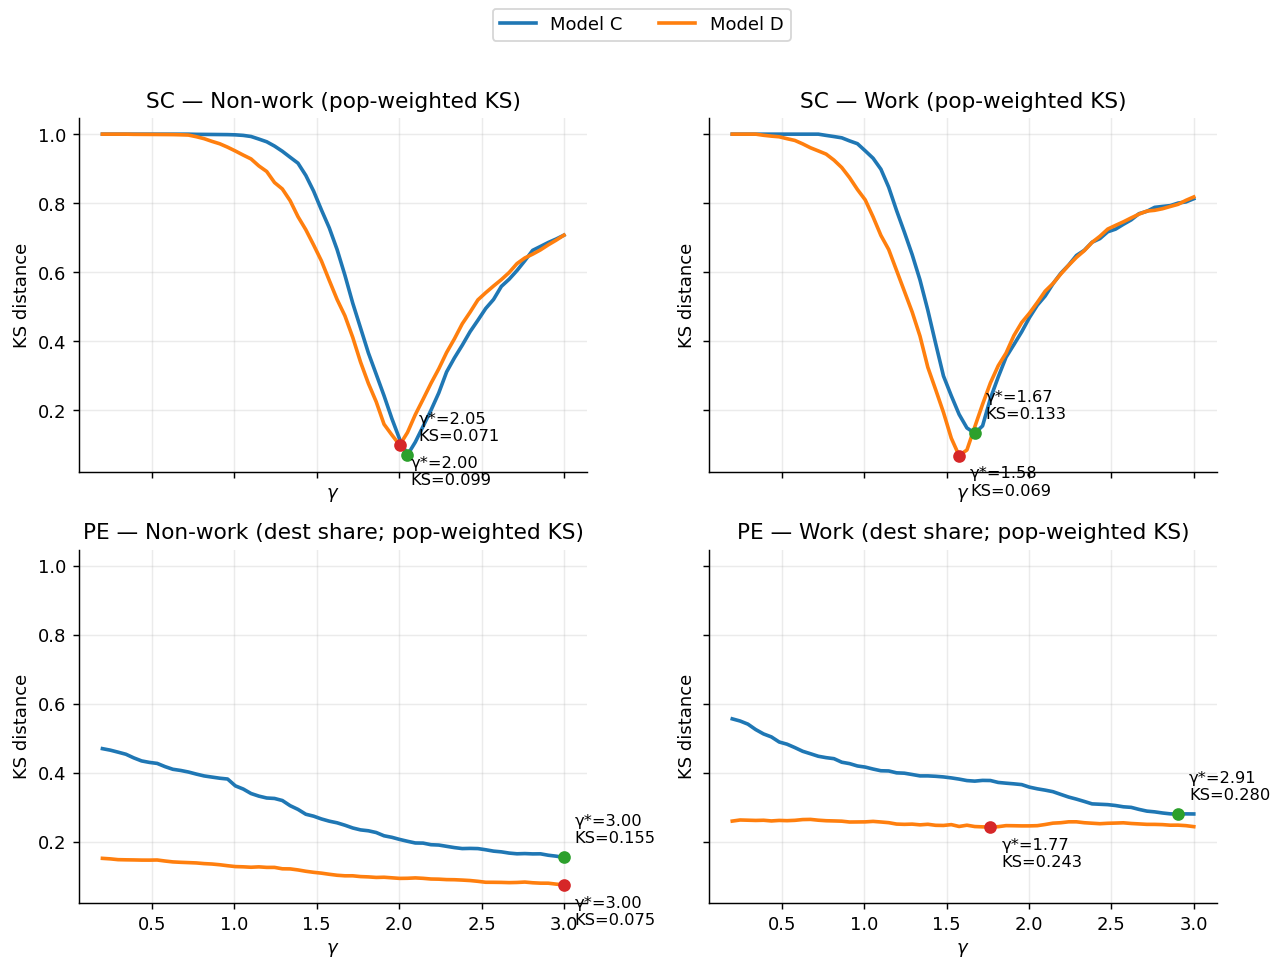

In [ ]:
# ---------- Data splits ----------
OT_nw_emp, IT_nw_emp = OT_IT_from(T_nw)
OT_w_emp , IT_w_emp  = OT_IT_from(T_w)
SC_nw_emp = SC_share_from(T_nw); SC_w_emp = SC_share_from(T_w)
PE_nw_emp = PE_dest_share_from(T_nw); PE_w_emp = PE_dest_share_from(T_w)
targets = {
    "nw": {"SC": SC_nw_emp, "IT": IT_nw_emp, "PE": PE_nw_emp, "OT": OT_nw_emp},
    "w" : {"SC": SC_w_emp , "IT": IT_w_emp , "PE": PE_w_emp , "OT": OT_w_emp }
}
datasets = {"nw": T_nw, "w": T_w}

# ============================================================
# 4g — SC & PE (scale-free), KS(γ) for Models C/D  [POP-WEIGHTED KS]
# ============================================================
print(f"\n[4g] SC & PE (scale-free) — N_sims={N_SIMS}")
ks_tr_SCPE = {k: {"C": np.full_like(GAMMA_GRID, np.nan, float),
                  "D": np.full_like(GAMMA_GRID, np.nan, float)}
              for k in ["SC_nw","SC_w","PE_nw","PE_w"]}
best_SCPE = {k: {"C": {"gamma": np.nan, "KS": np.inf},
                 "D": {"gamma": np.nan, "KS": np.inf}}
             for k in ["SC_nw","SC_w","PE_nw","PE_w"]}

for label in ["nw","w"]:
    T_emp = datasets[label]
    scpe_iter = enumerate(GAMMA_GRID)
    if USE_TQDM: scpe_iter = tqdm(scpe_iter, total=len(GAMMA_GRID), desc=f"[4g] {label} γ-scan", leave=True)
    for gi, g in scpe_iter:
        P_C = build_P_modelC(D_pos, g); P_D = build_P_modelD(D_pos, g, Pj_pop)
        SC_C, PE_C = mean_SC_PE_empOT(T_emp, P_C, N_sims=N_SIMS)
        SC_D, PE_D = mean_SC_PE_empOT(T_emp, P_D, N_sims=N_SIMS)
        # SC (pop-weighted KS):
        kSC = f"SC_{label}"
        ksC = ks_for("SC", targets[label]["SC"], SC_C, weights_pop)
        ksD = ks_for("SC", targets[label]["SC"], SC_D, weights_pop)
        ks_tr_SCPE[kSC]["C"][gi] = ksC; ks_tr_SCPE[kSC]["D"][gi] = ksD
        if ksC < best_SCPE[kSC]["C"]["KS"]: best_SCPE[kSC]["C"] = {"gamma": g, "KS": ksC}
        if ksD < best_SCPE[kSC]["D"]["KS"]: best_SCPE[kSC]["D"] = {"gamma": g, "KS": ksD}
        # PE (destination share; pop-weighted KS):
        kPE = f"PE_{label}"
        ksC = ks_for("PE", targets[label]["PE"], PE_C, weights_pop)
        ksD = ks_for("PE", targets[label]["PE"], PE_D, weights_pop)
        ks_tr_SCPE[kPE]["C"][gi] = ksC; ks_tr_SCPE[kPE]["D"][gi] = ksD
        if ksC < best_SCPE[kPE]["C"]["KS"]: best_SCPE[kPE]["C"] = {"gamma": g, "KS": ksC}
        if ksD < best_SCPE[kPE]["D"]["KS"]: best_SCPE[kPE]["D"] = {"gamma": g, "KS": ksD}

# Plot KS(γ) for SC/PE  → SAVE PDF
plot_ks_traces(
    ks_traces=ks_tr_SCPE,
    gamma_grid=GAMMA_GRID,
    title_pairs=[("SC_nw","SC — Non-work (pop-weighted KS)"),
                 ("SC_w","SC — Work (pop-weighted KS)"),
                 ("PE_nw","PE — Non-work (dest share; pop-weighted KS)"),
                 ("PE_w","PE — Work (dest share; pop-weighted KS)")],
    pdf_name="KS_SC_PE.pdf"  # [PDF]
)


# ============================================================
# Overlay plots (empirical vs optimized) + PDF export
# ============================================================

def _fd_bins(arr, cap=60, min_bins=20):
    """Freedman–Diaconis bin count with caps; arr can be 1D or list of arrays."""
    if isinstance(arr, (list, tuple)):
        data = np.concatenate([np.asarray(a, float).ravel() for a in arr])
    else:
        data = np.asarray(arr, float).ravel()
    data = data[np.isfinite(data)]
    if data.size < 2:
        return 30
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    if iqr <= 0:
        return 30
    bw = 2 * iqr / (data.size ** (1/3))
    if bw <= 0:
        return 30
    nb = int(np.ceil((data.max() - data.min()) / bw))
    return int(np.clip(nb, min_bins, cap))

# ---------- Helpers to compute model outputs at a given γ ----------
def _IT_scaled_from_gamma(label, gamma, model="C"):
    T_emp = datasets[label]
    if model == "C":
        P = build_P_modelC(D_pos, gamma)
    else:
        P = build_P_modelD(D_pos, gamma, Pj_pop)
    return mean_IT_reducedOT(T_emp, P, N_sims=N_SIMS, f=F_SCALE)

def _SC_PE_from_gamma(label, gamma, model="C"):
    T_emp = datasets[label]
    if model == "C":
        P = build_P_modelC(D_pos, gamma)
    else:
        P = build_P_modelD(D_pos, gamma, Pj_pop)
    return mean_SC_PE_empOT(T_emp, P, N_sims=N_SIMS)


# ---------- Overlay: SC or PE at per-quantity γ* (pop-weighted) ----------
def overlay_SC_or_PE_per_quantity(label, quantity="SC", filename=None, bins=None, pe_xlim_factor=1.05):
    assert quantity in ("SC","PE")
    x_emp = targets[label][quantity]
    if quantity == "SC":
        gC = best_SCPE[f"SC_{label}"]["C"]["gamma"]
        gD = best_SCPE[f"SC_{label}"]["D"]["gamma"]
        SC_C, _ = _SC_PE_from_gamma(label, gC, model="C")
        SC_D, _ = _SC_PE_from_gamma(label, gD, model="D")
        xC, xD = SC_C, SC_D
        if bins is None: bins = np.linspace(0.0, 1.0, 41)
        xlabel = r"$\mathrm{SC}(i)$"; xlim = (0,1)
        ttl = f"SC {label.upper()} — Per-quantity γ*: Empirical (pop-wt) vs C/D"
    else:
        gC = best_SCPE[f"PE_{label}"]["C"]["gamma"]
        gD = best_SCPE[f"PE_{label}"]["D"]["gamma"]
        _, PE_C = _SC_PE_from_gamma(label, gC, model="C")
        _, PE_D = _SC_PE_from_gamma(label, gD, model="D")
        xC, xD = PE_C, PE_D
        all_vals = np.concatenate([x_emp[np.isfinite(x_emp)], xC[np.isfinite(xC)], xD[np.isfinite(xD)]])
        xmax = np.percentile(all_vals, 99.5) if all_vals.size else 1.0
        if bins is None: bins = np.linspace(0.0, float(xmax), 40)
        xlabel = r"$\mathrm{PE}(i)$ (destination share)"; xlim = (0, float(xmax*pe_xlim_factor))
        ttl = f"PE {label.upper()} — Per-quantity γ*: Empirical (pop-wt) vs C/D"

    valid = np.isfinite(x_emp) & np.isfinite(weights_pop) & (weights_pop >= 0)
    w = weights_pop[valid]
    fig, ax = plt.subplots(figsize=(7.8, 4.6))
    ax.hist(x_emp[valid], bins=bins, density=True, weights=w, alpha=0.55, label="Empirical (pop-weighted)")
    ax.hist(xC[valid],    bins=bins, density=True, weights=w, histtype='step', linewidth=2.0, label=f"Model C (γ*={gC:.2f})")
    ax.hist(xD[valid],    bins=bins, density=True, weights=w, histtype='step', linewidth=2.0, label=f"Model D (γ*={gD:.2f})")
    ax.set_xlabel(xlabel); ax.set_ylabel("Population-weighted density")
    ax.set_title(ttl); ax.set_xlim(*xlim)
    ax.legend()
    try: plt.tight_layout()
    except: pass
    if filename:
        plt.savefig(os.path.join(PDF_DIR, filename), bbox_inches="tight")
        print(f"[Saved] {os.path.join(PDF_DIR, filename)}")
    plt.show()

# ------------------------------
# Generate and SAVE all overlays
# ------------------------------

# SC: per-quantity γ*
#overlay_SC_or_PE_per_quantity("nw", quantity="SC", filename="overlay_SC_nw_perquantity.pdf")
#overlay_SC_or_PE_per_quantity("w",  quantity="SC", filename="overlay_SC_w_perquantity.pdf")

# PE: per-quantity γ*
#overlay_SC_or_PE_per_quantity("nw", quantity="PE", filename="overlay_PE_nw_perquantity.pdf")
#overlay_SC_or_PE_per_quantity("w",  quantity="PE", filename="overlay_PE_w_perquantity.pdf")



# ----------------- end of code ---------------------